In [1]:
import requests
from bs4 import BeautifulSoup
from io import StringIO
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [3]:
df_circuits = pd.read_csv("/Users/lilianagocko/Desktop/stydy_3_2/ML/Semester_project/data/circuits.csv")
df_constructors = pd.read_csv("/Users/lilianagocko/Desktop/stydy_3_2/ML/Semester_project/data/constructors.csv")
df_constructor_results = pd.read_csv("/Users/lilianagocko/Desktop/stydy_3_2/ML/Semester_project/data/constructor_results.csv")
df_constructor_standings = pd.read_csv("/Users/lilianagocko/Desktop/stydy_3_2/ML/Semester_project/data/constructor_standings.csv")
df_driver_standings = pd.read_csv("/Users/lilianagocko/Desktop/stydy_3_2/ML/Semester_project/data/driver_standings.csv")
df_drivers = pd.read_csv("/Users/lilianagocko/Desktop/stydy_3_2/ML/Semester_project/data/drivers.csv")
df_lap_times = pd.read_csv("/Users/lilianagocko/Desktop/stydy_3_2/ML/Semester_project/data/lap_times.csv")
df_pit_stops = pd.read_csv("/Users/lilianagocko/Desktop/stydy_3_2/ML/Semester_project/data/pit_stops.csv")
df_qualifying = pd.read_csv("/Users/lilianagocko/Desktop/stydy_3_2/ML/Semester_project/data/qualifying.csv")
df_results = pd.read_csv("/Users/lilianagocko/Desktop/stydy_3_2/ML/Semester_project/data/results.csv")
df_seasons = pd.read_csv("/Users/lilianagocko/Desktop/stydy_3_2/ML/Semester_project/data/seasons.csv")
df_sprint_results = pd.read_csv("/Users/lilianagocko/Desktop/stydy_3_2/ML/Semester_project/data/sprint_results.csv")
df_status = pd.read_csv("/Users/lilianagocko/Desktop/stydy_3_2/ML/Semester_project/data/status.csv")
df_races = pd.read_csv("/Users/lilianagocko/Desktop/stydy_3_2/ML/Semester_project/data/races.csv")
df_weather = pd.read_csv("/Users/lilianagocko/Desktop/stydy_3_2/ML/Semester_project/data/weather.csv")
df_status = pd.read_csv("/Users/lilianagocko/Desktop/stydy_3_2/ML/Semester_project/data/status.csv")

In [17]:
df_weather.drop(columns='Time', inplace=True)
def weatherAverage(df_weather, year):
    df_year = df_weather[df_weather['Year'] == year]
    df_weather = df_weather[df_weather['Year'] != year]
    df_year = df_year.groupby('Round Number').mean().round(1).reset_index()
    df_weather = pd.concat([df_weather, df_year])
    return df_weather

for year in  [x for x in range(2010, 2020)]:
    df_weather = weatherAverage(df_weather, year)
df_weather = df_weather.rename(columns={"Year": "year", "Round Number": "round"})
df_weather = pd.merge(df_weather, df_races[['raceId', 'circuitId', 'year', 'round']], on=['year', 'round'], how='left')

In [ ]:
threshold = 0.5
percentage_rain = (((df_weather['Rainfall'] > threshold).sum() / len(df_weather)) * 100).round(2)
races_in_rain = df_weather[df_weather['Rainfall']>0]
df_rain_grid_wins = df_grid_wins[df_grid_wins['raceId'].isin(races_in_rain['raceId'])]
mean_wins_by_grid = (df_rain_grid_wins.groupby('grid')['Win'].mean()*100).round(2)

In [24]:

df_constructor_experience = df_results[['raceId', 'constructorId', 'date']].sort_values('date')
df_constructor_experience['Constructor Experience'] = df_constructor_experience.groupby('constructorId').cumcount() + 1


In [33]:
formula_1 = formula_1.drop_duplicates(subset=['raceId', 'driverId', 'constructorId'], keep='last')
pos = list(range(1, 21))
formula_1 = formula_1[formula_1['position'].isin(pos)]
formula_1 = formula_1[formula_1['Constructor Wins'].notnull()]
formula_1 = formula_1[formula_1['date']>='1990-01-01']
formula_1['podium'] = formula_1['position'].apply(lambda x: x if 1<=x<=3 else 0)

formula_1.to_csv('formula1.csv', index=False)


In [52]:
from sklearn.model_selection import train_test_split


X = formula_1.drop(['position', 'seconds', 'podium', 'date', 'fastestLapSpeed', 'raceId'], axis=1)
y = formula_1['podium'] 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [37]:

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
rfc_accuracy = accuracy_score(y_test, y_pred)
rfc_cv = cross_val_score(formula1_predict, X, y, cv=5)
print(f"Accuracy of the Random Forest Classifier: {rfc_accuracy*100:.2f}%")
print(f"Average cross-validation score: {rfc_cv.mean()*100:.2f}%")

Accuracy of the Random Forest Classifier: 100.00%
Average cross-validation score: 99.15%


In [39]:
def prediction(driver_name, grid, circuit_loc):
    driver = df_drivers.loc[df_drivers['Name']==driver_name, 'driverId'].iloc[0]
    input_data = formula_1[formula_1['driverId'] == driver].sort_values(by='date', ascending=False).iloc[0]
    circuit_data = df_circuits[df_circuits['location']==circuit_loc].iloc[0]

    features = {
        'driverId': input_data['driverId'],
        'constructorId': input_data['constructorId'],
        'grid': grid,
        'laps': circuit_data['laps'],
        'circuitId': circuit_data['circuitId'],
        'Length': circuit_data['Length'],
        'Turns': circuit_data['Turns'],
        'Constructor Experience': input_data['Constructor Experience'],
        'Driver Experience': input_data['Driver Experience'],
        'Driver Age': input_data['Driver Age'],
        'Driver Wins': input_data['Driver Wins'],
        'Constructor Wins': input_data['Constructor Wins'],
        'Driver Constructor Experience': input_data['Driver Constructor Experience'],
        'DNF Score': input_data['DNF Score'],
        'prev_position': input_data['prev_position']
    }
    features = pd.DataFrame([features])
    return formula1_predict.predict(features), formula1_predict.predict_proba(features)

In [62]:
drivers = ['Max Verstappen', 'Charles Leclerc', 'George Russell', 'Carlos Sainz', 'Sergio Pérez', 'Fernando Alonso', 'Lando Norris', 'Oscar Piastri', 'Lewis Hamilton', 'Nico Hülkenberg', 'Yuki Tsunoda', 'Lance Stroll', 'Alexander Albon', 'Daniel Ricciardo', 'Kevin Magnussen', 'Valtteri Bottas', 'Logan Sargeant', 'Esteban Ocon', 'Pierre Gasly']

grids = list(range(1, 21))

circuit_loc = 'Sakhir'
expected = []
predicted = []
for driver_name, grid in zip(drivers, grids):
    pred, prob = prediction(driver_name, grid, circuit_loc)
    print(f'{driver_name}, Expected: {grid}, Predicted: {pred[0]}, prob: {prob[0]}')
    expected.append(grid)
    predicted.append(pred[0])


Max Verstappen, Expected: 1, Predicted: 1, prob: [0. 1. 0. 0.]
Charles Leclerc, Expected: 2, Predicted: 3, prob: [0.08 0.06 0.16 0.7 ]
George Russell, Expected: 3, Predicted: 0, prob: [0.9  0.02 0.04 0.04]
Carlos Sainz, Expected: 4, Predicted: 0, prob: [0.98 0.   0.02 0.  ]
Sergio Pérez, Expected: 5, Predicted: 2, prob: [0.06 0.08 0.78 0.08]
Fernando Alonso, Expected: 6, Predicted: 0, prob: [0.98 0.   0.02 0.  ]
Lando Norris, Expected: 7, Predicted: 0, prob: [0.96 0.   0.04 0.  ]
Oscar Piastri, Expected: 8, Predicted: 0, prob: [1. 0. 0. 0.]
Lewis Hamilton, Expected: 9, Predicted: 0, prob: [0.94 0.02 0.   0.04]
Nico Hülkenberg, Expected: 10, Predicted: 0, prob: [1. 0. 0. 0.]
Yuki Tsunoda, Expected: 11, Predicted: 0, prob: [1. 0. 0. 0.]
Lance Stroll, Expected: 12, Predicted: 0, prob: [1. 0. 0. 0.]
Alexander Albon, Expected: 13, Predicted: 0, prob: [1. 0. 0. 0.]
Daniel Ricciardo, Expected: 14, Predicted: 0, prob: [1. 0. 0. 0.]
Kevin Magnussen, Expected: 15, Predicted: 0, prob: [0.98 0.   

In [ ]:

accuracy = sum([e == p for e, p in zip(expected, predicted)]) / len(expected)


In [66]:
df_circuits['location']

0        Melbourne
1     Kuala Lumpur
2           Sakhir
3         Montmeló
4         Istanbul
          ...     
72        Portimão
73         Mugello
74          Jeddah
75       Al Daayen
76           Miami
Name: location, Length: 77, dtype: object

In [60]:
!pip install scikit-learn

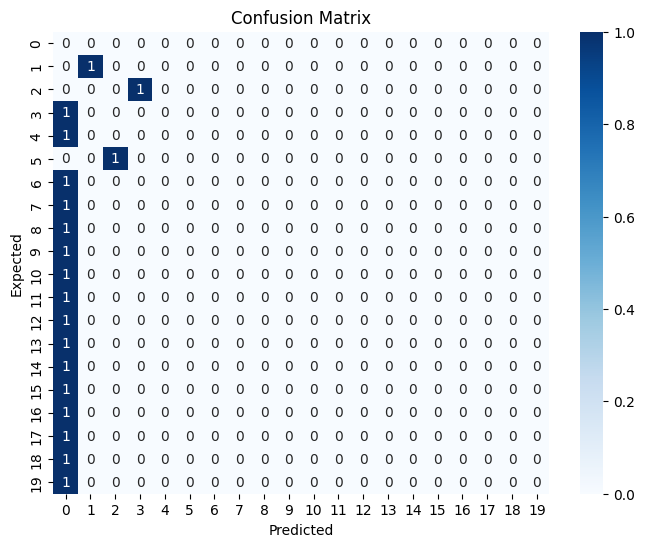

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(expected, predicted)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Expected")
plt.title("Confusion Matrix")
plt.show()

In [64]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(expected, predicted, average='weighted', zero_division=1)
recall = recall_score(expected, predicted, average='weighted', zero_division=1)


In [65]:
precision, recall

(0.8947368421052632, 0.05263157894736842)

In [77]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

X = formula_1.drop(['position', 'seconds', 'podium', 'date', 'fastestLapSpeed', 'raceId'], axis=1)
y = formula_1['podium'] 

initial_train_size = 0.5
increment = 0.05

formula1_gb = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42))
])

train_sizes = []
accuracy_scores = []
current_train_size = initial_train_size

while current_train_size <= 0.9:  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - current_train_size, random_state=42)  
    X_test = X_test[:20]
    y_test = y_test[:20]
    formula1_gb.fit(X_train, y_train)
    y_pred = formula1_gb.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    train_sizes.append(current_train_size)
    accuracy_scores.append(accuracy)

    current_train_size += increment


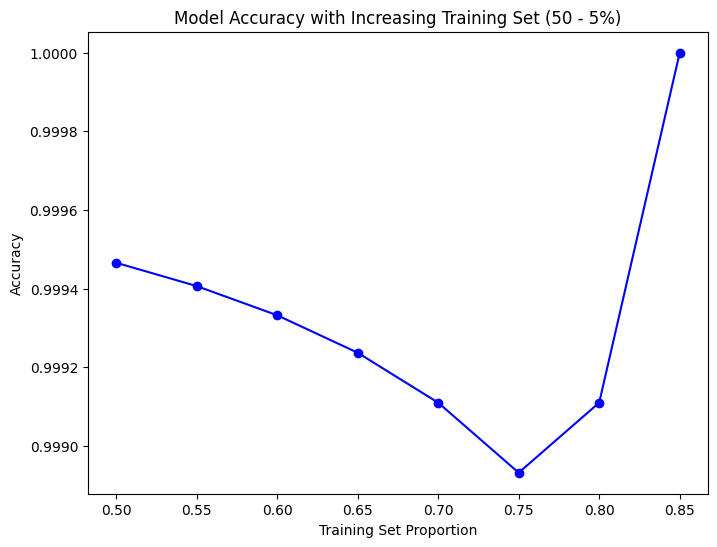

In [71]:

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, accuracy_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Training Set Proportion')
plt.ylabel('Accuracy')
plt.title('Model Accuracy with Increasing Training Set (50 - 5%)')
plt.show()
